# Task - 3

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 540.6 kB/s eta 0:00:00


In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-09-19 16:35:51--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 54.230.18.18, 54.230.18.79, 54.230.18.11, ...
Connecting to segment-anything.com (segment-anything.com)|54.230.18.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.05s   

2024-09-19 16:35:51 (4.44 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


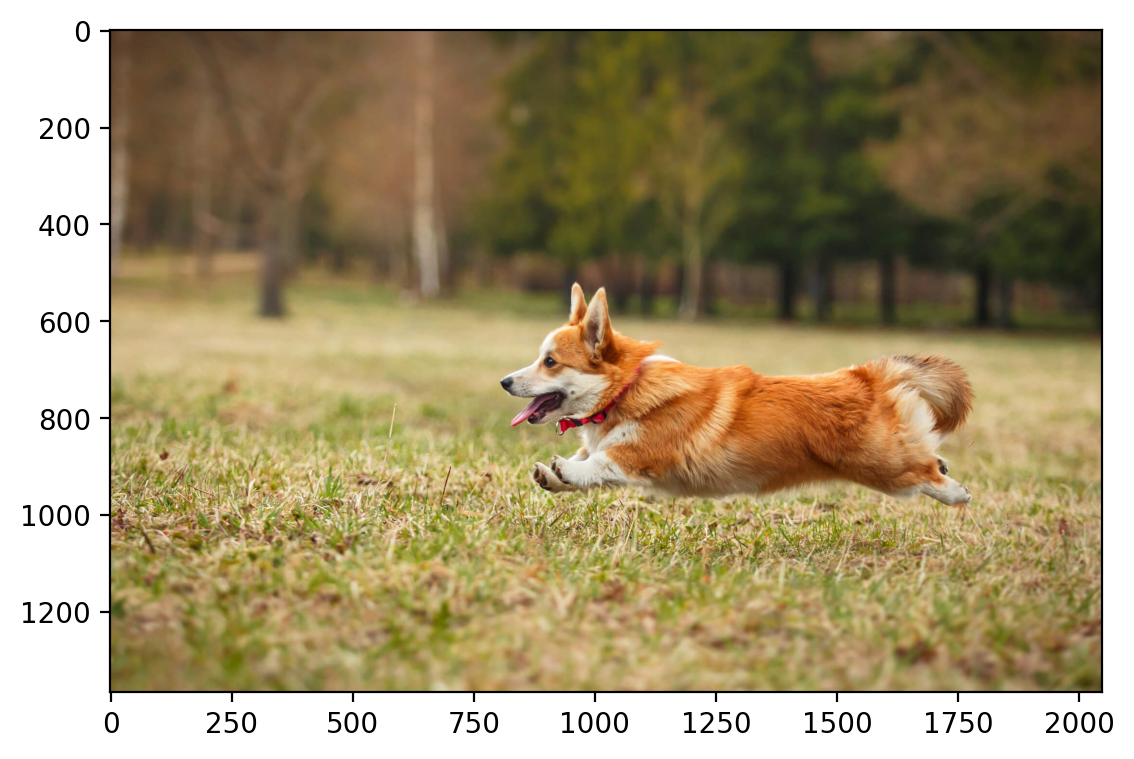

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [7]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
crop.shape

torch.Size([3, 400, 400])

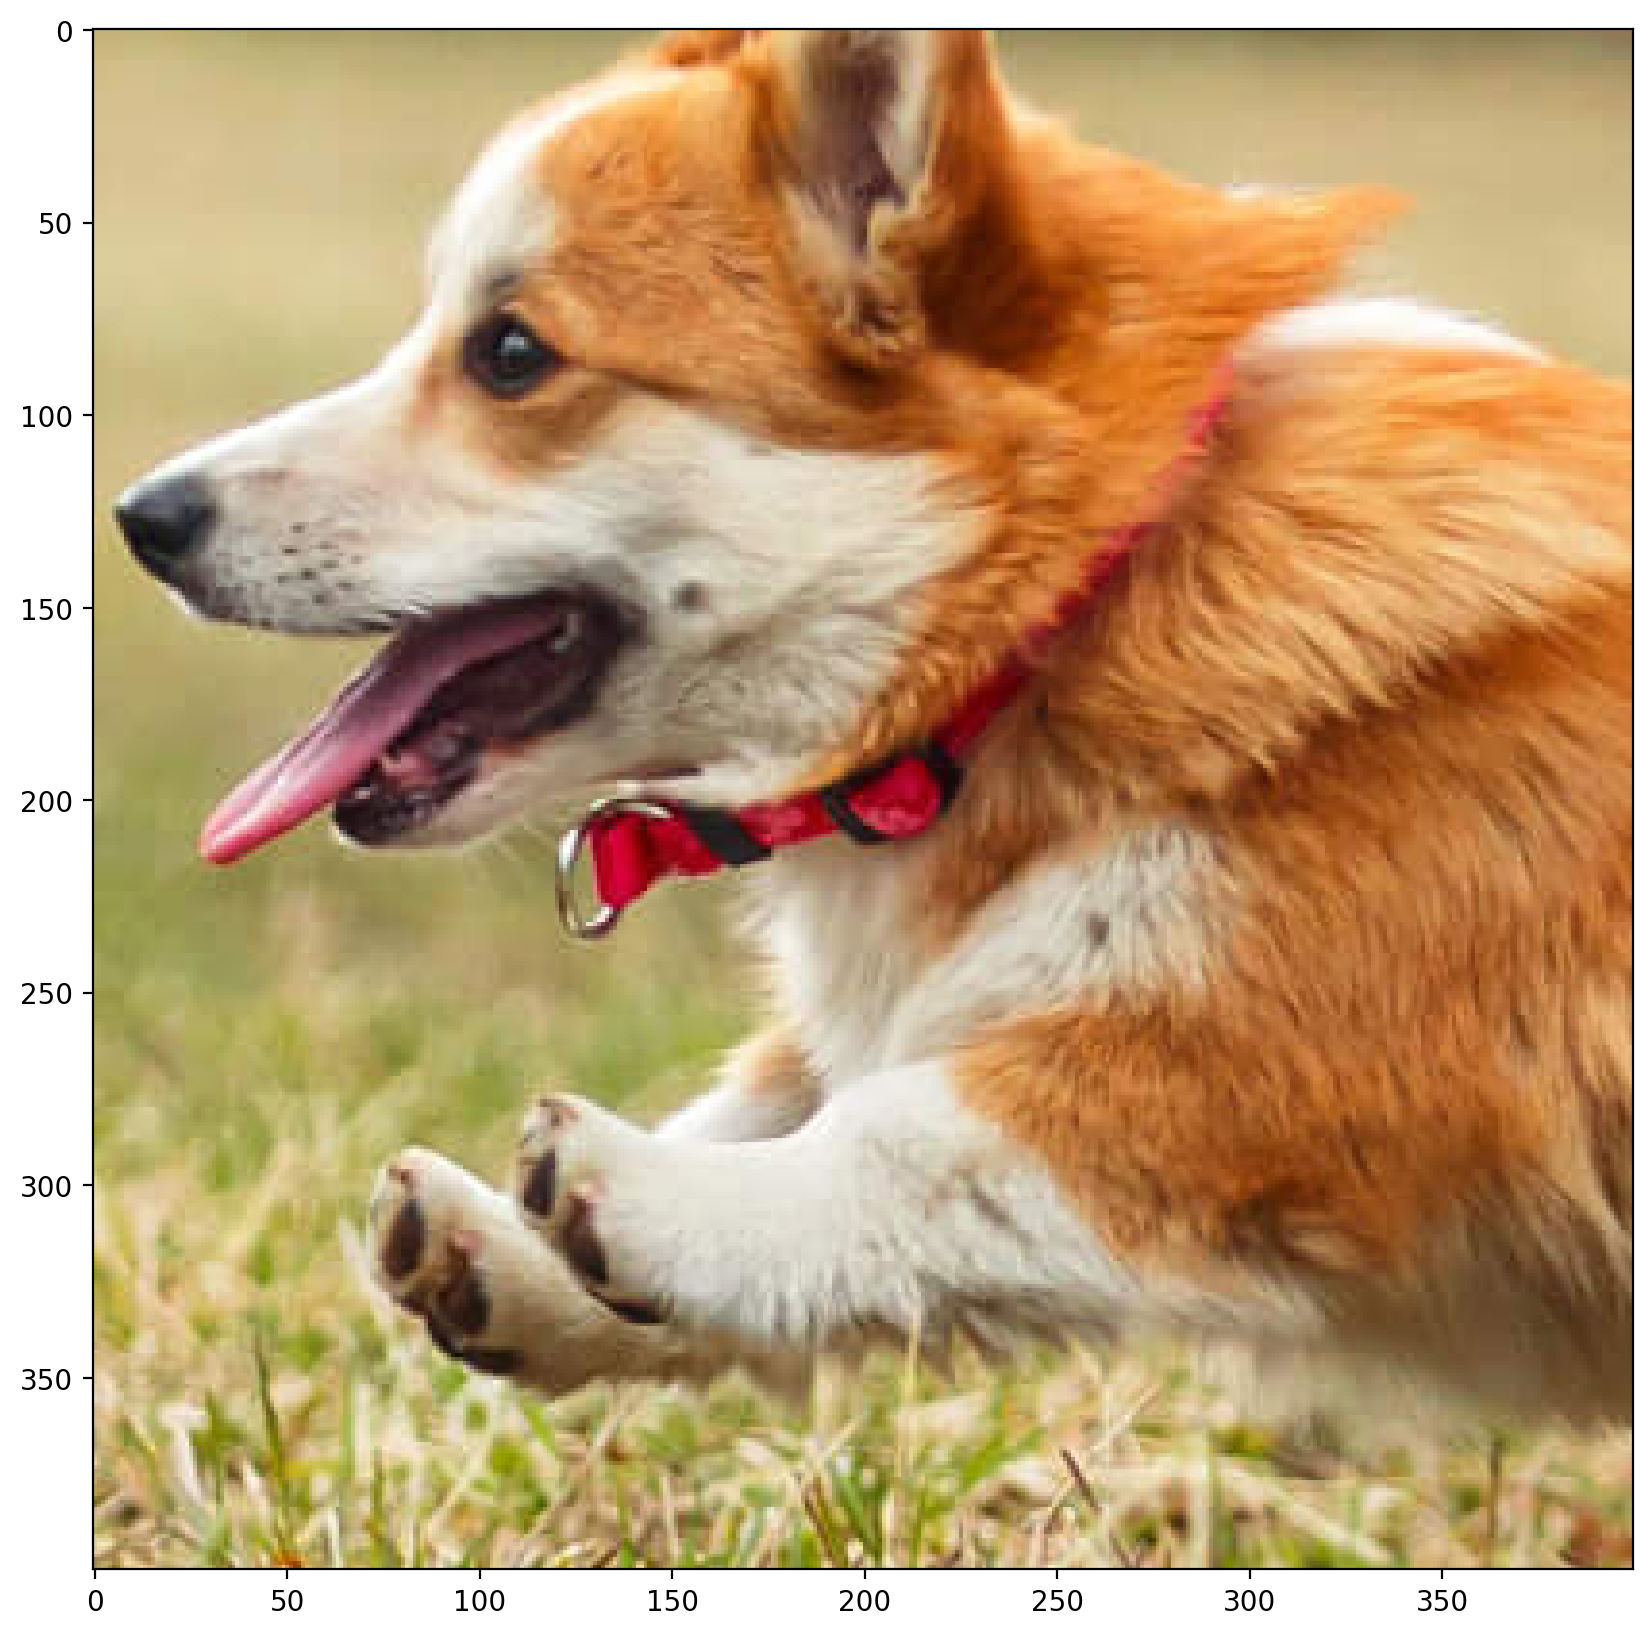

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [9]:
def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    height *= scale
    width *= scale

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float().to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [10]:
crop = crop.to(device)

In [11]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 400 400


In [12]:
scale = 2
num_channels, height, width = crop.shape
height //= scale
width //= scale
low_res_img = torch.zeros((num_channels,height,width)).to(device)
for i in range(height):
  for j in range(width):
    low_res_img[:, i, j] = torch.mean(crop[:, 2*i:2*i+2, 2*j:2*j+2], dim=(1, 2))
print(low_res_img.shape)

torch.Size([3, 200, 200])


In [13]:
import gc

gc.collect()

10

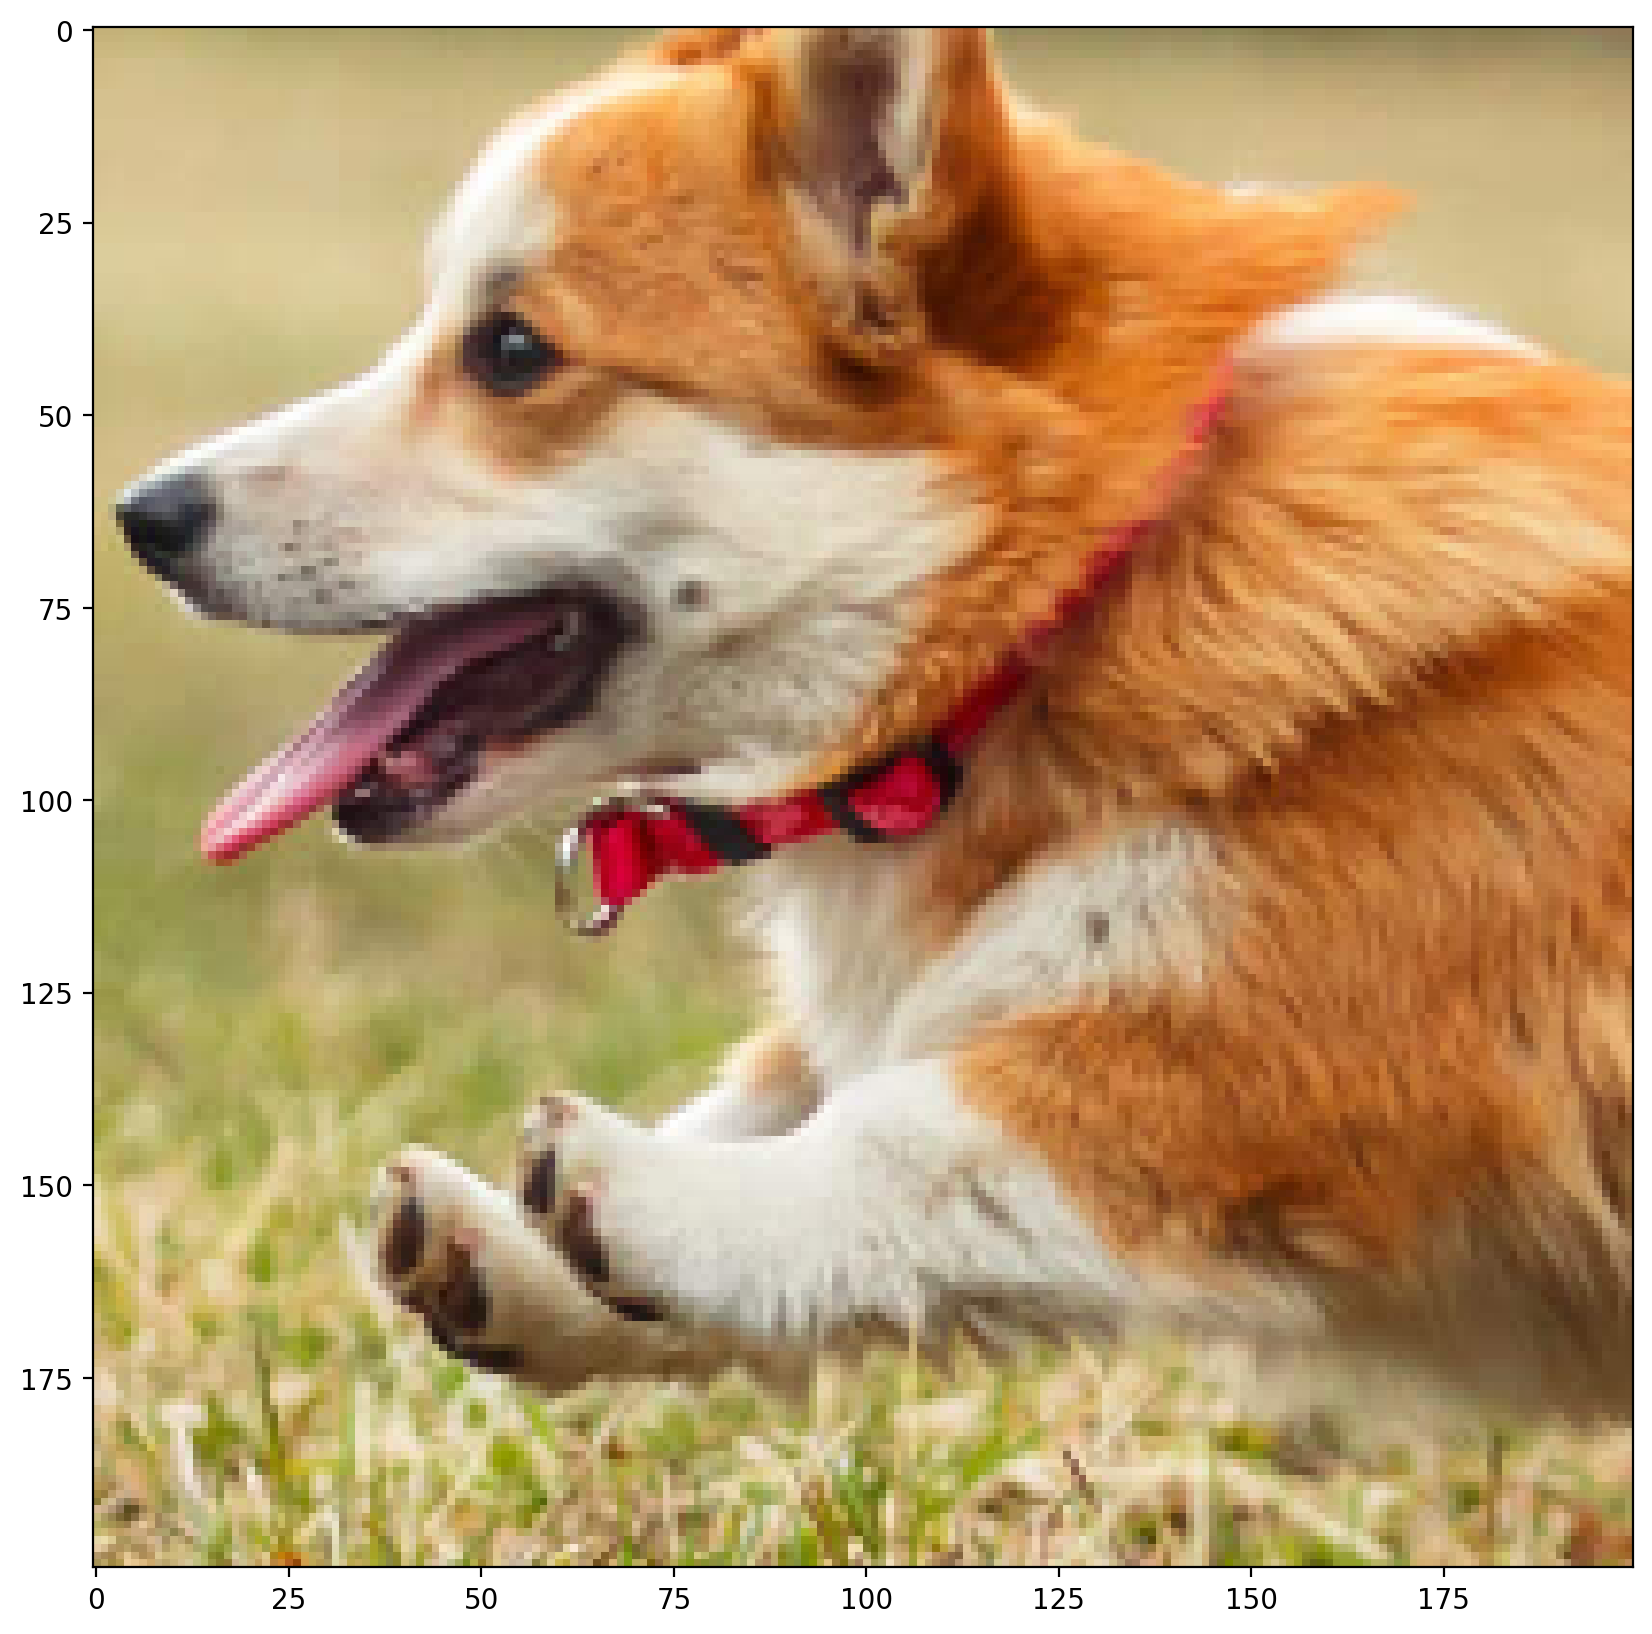

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(low_res_img, 'c h w -> h w c').cpu().numpy())

In [15]:

dog_X, dog_Y = create_coordinate_map(low_res_img)

dog_X.shape, dog_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [16]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).float().to(device)



In [17]:
num_features = 37500
sigma = 0.03

from sklearn.kernel_approximation import RBFSampler
rff = RBFSampler(n_components=num_features, gamma=1/(2*sigma**2), random_state=42)
X_rff = torch.tensor(rff.fit_transform(dog_X_scaled.cpu().numpy())).float().to(device)
print(X_rff.shape)

torch.Size([40000, 37500])


In [18]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [19]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    print(f"Epoch {epochs} loss: {loss.item():.6f}")
    return loss.item()

In [20]:
in_features = X_rff.shape[1]
out_features = 3
net = LinearModel(in_features,out_features).to(device)
net
dog_Y = dog_Y.to(device)
train(net, 0.1, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.369796
Epoch 100 loss: 0.001756
Epoch 200 loss: 0.001734
Epoch 300 loss: 0.001734
Epoch 400 loss: 0.001785
Epoch 500 loss: 0.001761
Epoch 600 loss: 0.001765
Epoch 700 loss: 0.001798
Epoch 800 loss: 0.001780
Epoch 900 loss: 0.001825
Epoch 1000 loss: 0.001816
Epoch 1100 loss: 0.001827
Epoch 1200 loss: 0.001852
Epoch 1300 loss: 0.001851
Epoch 1400 loss: 0.001876
Epoch 1500 loss: 0.001881
Epoch 1600 loss: 0.001852
Epoch 1700 loss: 0.001842
Epoch 1800 loss: 0.001864
Epoch 1900 loss: 0.001906
Epoch 2000 loss: 0.001867
Epoch 2100 loss: 0.001831
Epoch 2200 loss: 0.001835
Epoch 2300 loss: 0.001844
Epoch 2400 loss: 0.001886
Epoch 2500 loss: 0.001888


0.0018876506946980953

In [21]:
import gc
del X_rff, dog_X, dog_Y, dog_X_scaled
gc.collect()

0

In [22]:
X_, Y_ = create_coordinate_map(low_res_img, scale = 2)
print("Shape of X_ = ",X_.shape,"\nShape of Y_ = ", Y_.shape)
print("X_:\n",X_,"\nY_:\n", Y_)

Shape of X_ =  torch.Size([160000, 2]) 
Shape of Y_ =  torch.Size([40000, 3])
X_:
 tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [399., 397.],
        [399., 398.],
        [399., 399.]]) 
Y_:
 tensor([[0.7706, 0.6961, 0.4765],
        [0.7706, 0.6961, 0.4765],
        [0.7706, 0.6961, 0.4765],
        ...,
        [0.6245, 0.5020, 0.1912],
        [0.6814, 0.5206, 0.2608],
        [0.7373, 0.5461, 0.3461]])


In [23]:
scaler = preprocessing.MinMaxScaler(feature_range= (-1,1)).fit(X_.cpu())
scaled_X_ = torch.tensor(scaler.transform(X_.cpu())).float().to(device)
print(scaled_X_.shape)
print(scaled_X_)


torch.Size([160000, 2])
tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9900],
        ...,
        [ 1.0000,  0.9900],
        [ 1.0000,  0.9950],
        [ 1.0000,  1.0000]])


In [24]:
X_rff = rff.transform(scaled_X_.cpu().numpy())
X_rff = torch.tensor(X_rff).float().to(device)

In [25]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [26]:
def plot_Original_vs_Predicted_Img(OriginalImg, X_rff_pred, net, return_Output = 0):
    """
    OriginalImg: torch.Tensor of shape (num_channels, height, width)
    X_rff_pred: torch.Tensor of shape (num_samples, num_features)
    net: torch.nn.Module
    return_Output: int
    return: torch.Tensor of shape (num_channels, scale*height, scale*width)

    """
    num_channels, height, width = OriginalImg.shape

    with torch.no_grad():
        outputs = net(X_rff_pred)
        pred_img = outputs.to(device)
        print(pred_img.shape)
        pred_img = rearrange(pred_img, '(h w) c -> c h w', h=height, w=width)
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Original Image ({height}x{width})')
    ax0.imshow(rearrange(OriginalImg, 'c h w -> h w c').cpu().numpy())

    ax1 = plt.subplot(gs[1])
    ax1.set_title(f'Predicted Image ({height}x{width})')
    ax1.imshow(rearrange(pred_img,'c h w -> h w c').cpu().detach().numpy())

    fig.suptitle('Original vs Predicted Image',fontsize=16, y=0.95)
    plt.tight_layout()
    if(return_Output == 1):
        return pred_img

torch.Size([160000, 3])


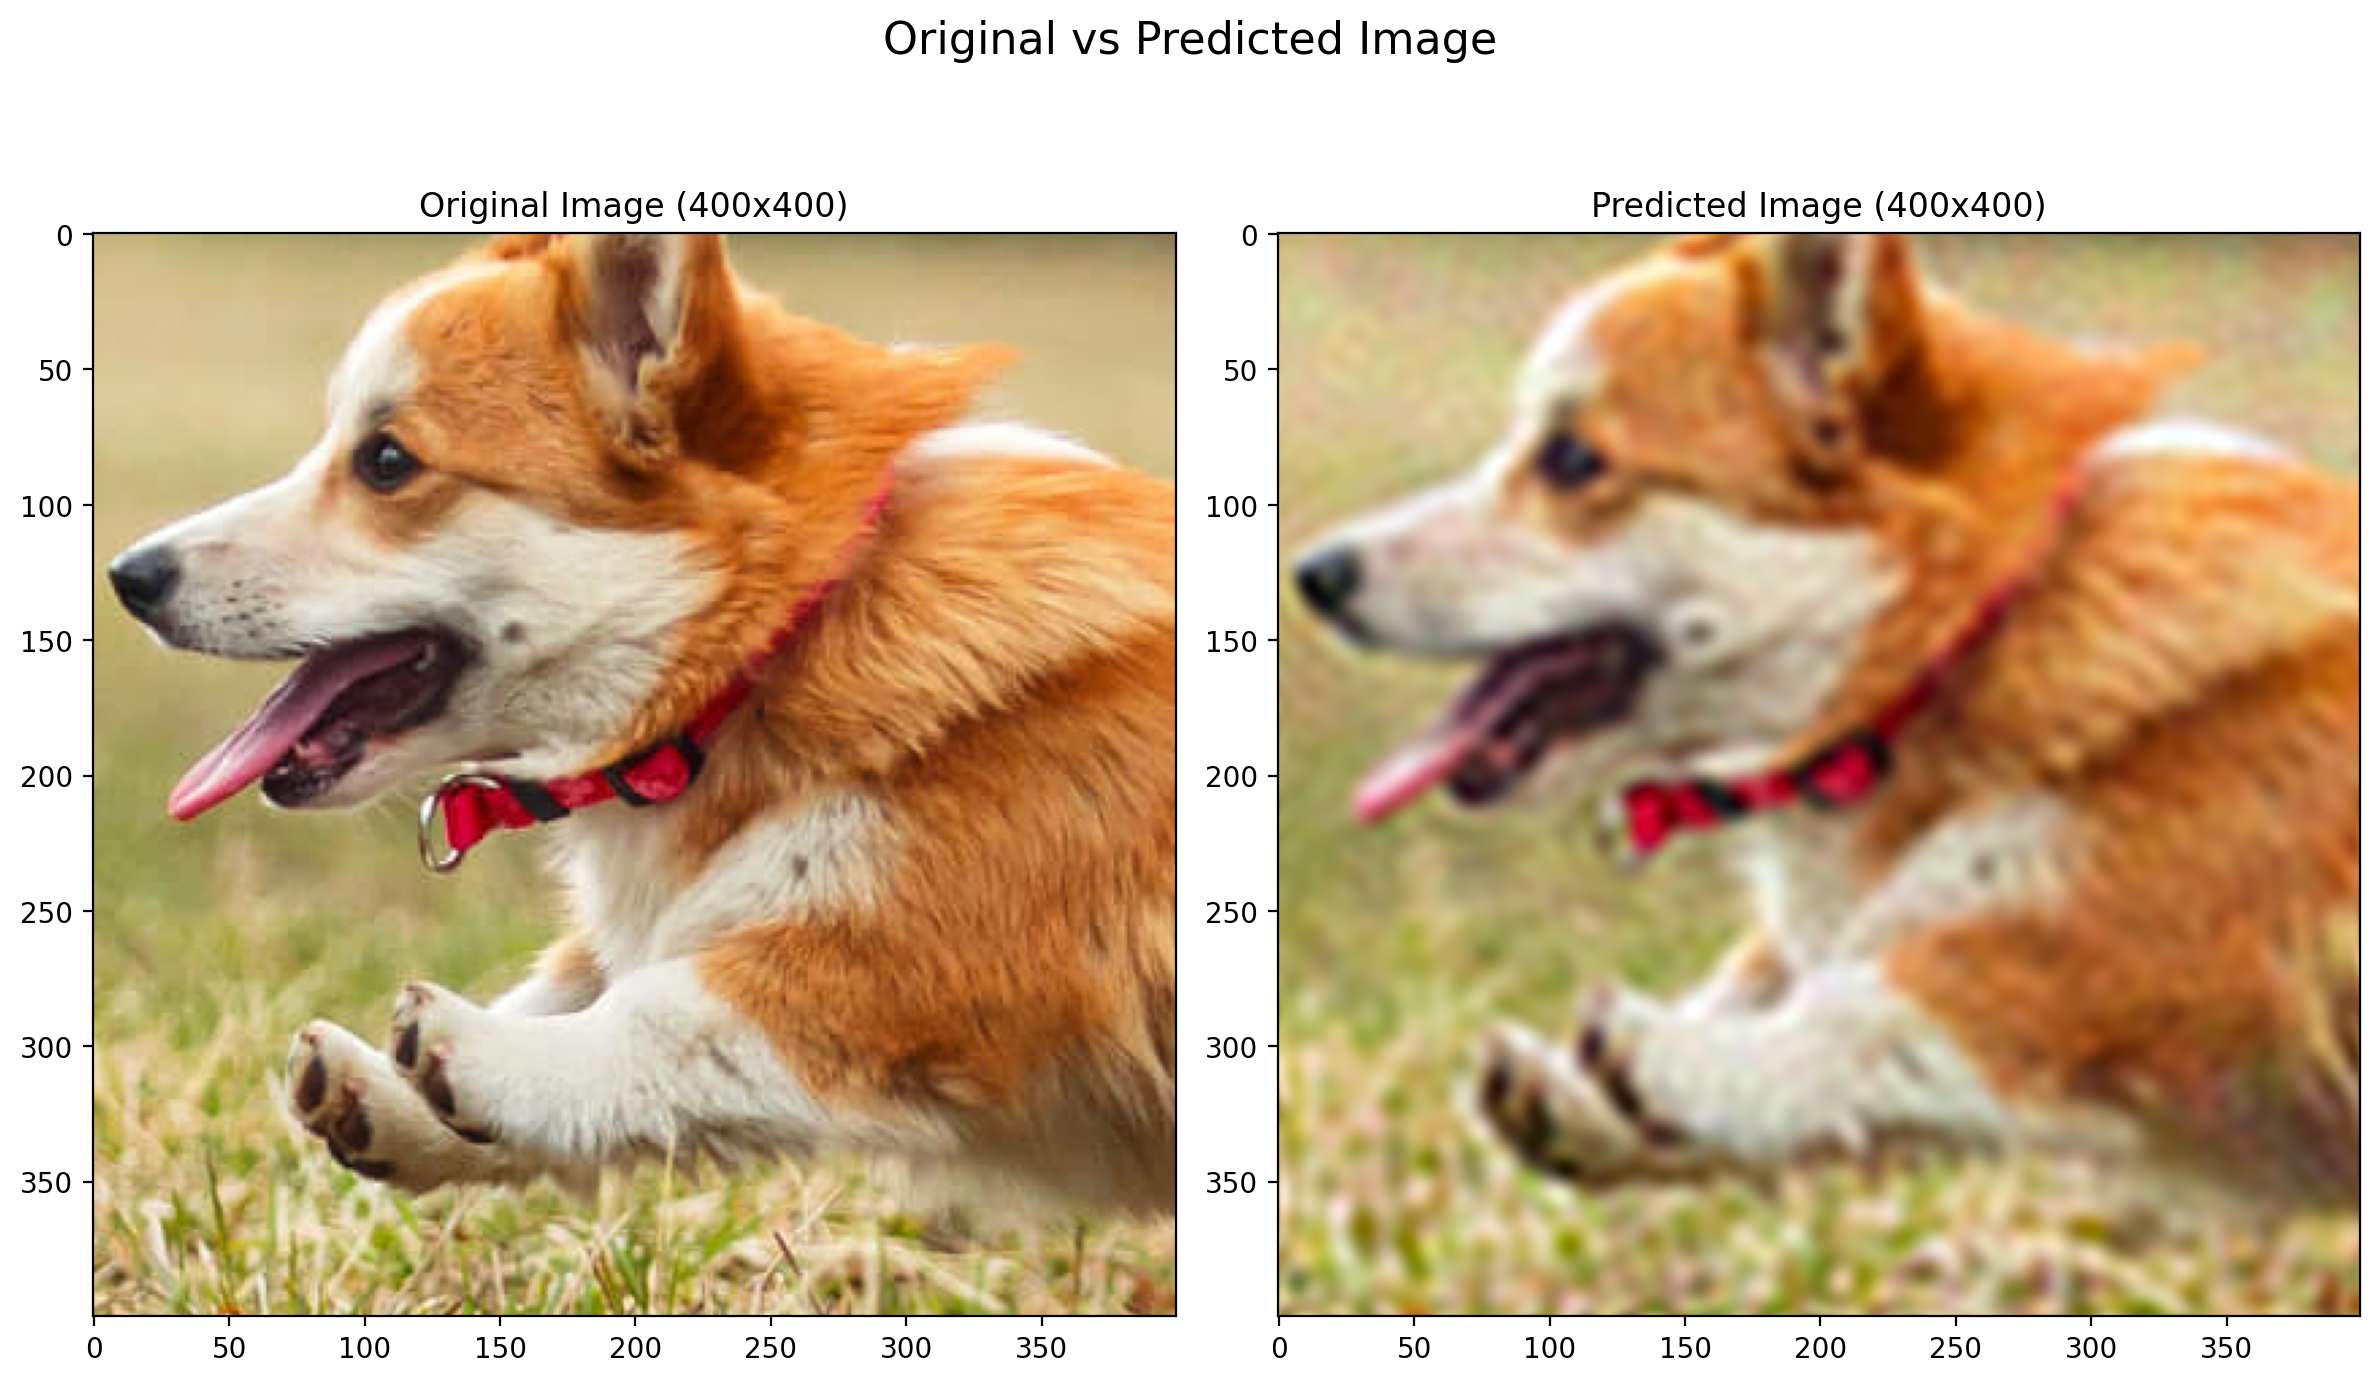

In [28]:
# plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

Y = plot_Original_vs_Predicted_Img(crop, X_rff, net, return_Output = 1)

In [29]:
def calRMSE_and_PSNR(img1, img2):
    """
    img1: torch.Tensor of shape (num_channels, height, width)
    img2: torch.Tensor of shape (num_channels, height, width)

    return: tuple of float and float
    """
    device = img1.device
    img2 = img2.to(device)

    rmse = torch.sqrt(torch.mean((img1 - img2) ** 2))
    psnr = 20 * torch.log10(1.0 / rmse)
    return rmse.item(), psnr.item()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
crop = crop.to(device)
Y = Y.to(device)

rmse, psnr = calRMSE_and_PSNR(crop, Y)
print("RMSE: ", rmse, "\nPSNR: ", psnr)

RMSE:  0.04957722212471314 
PSNR:  26.094356219256802
